**Prony Series Parameters**  
**Mean Absolute Percentage Error (MAPE)**

Terms: 1, MAPE (avg): 31.7286%
Terms: 2, MAPE (avg): 16.5723%
Terms: 3, MAPE (avg): 8.6655%
Terms: 4, MAPE (avg): 7.0501%
Terms: 5, MAPE (avg): 7.0501%
Terms: 6, MAPE (avg): 6.8808%
Terms: 7, MAPE (avg): 7.0517%
Terms: 8, MAPE (avg): 7.0567%
Terms: 9, MAPE (avg): 6.9825%
Terms: 10, MAPE (avg): 7.0647%
Best fit achieved with 6 terms. MAPE: 6.8808%

Final Results:
Optimized long-term modulus (E0): 921.43 Pa
Number of Prony terms: 6
Prony series parameters:
g1 = 0.2252, tau1 = 0.3362 s
g2 = 0.1090, tau2 = 5.9193 s
g3 = 0.0018, tau3 = 60.7963 s
g4 = 0.1370, tau4 = 62.7332 s
g5 = 0.3958, tau5 = 0.0629 s
g6 = 0.1363, tau6 = 1.3519 s
Sum of g_i: 1.0051


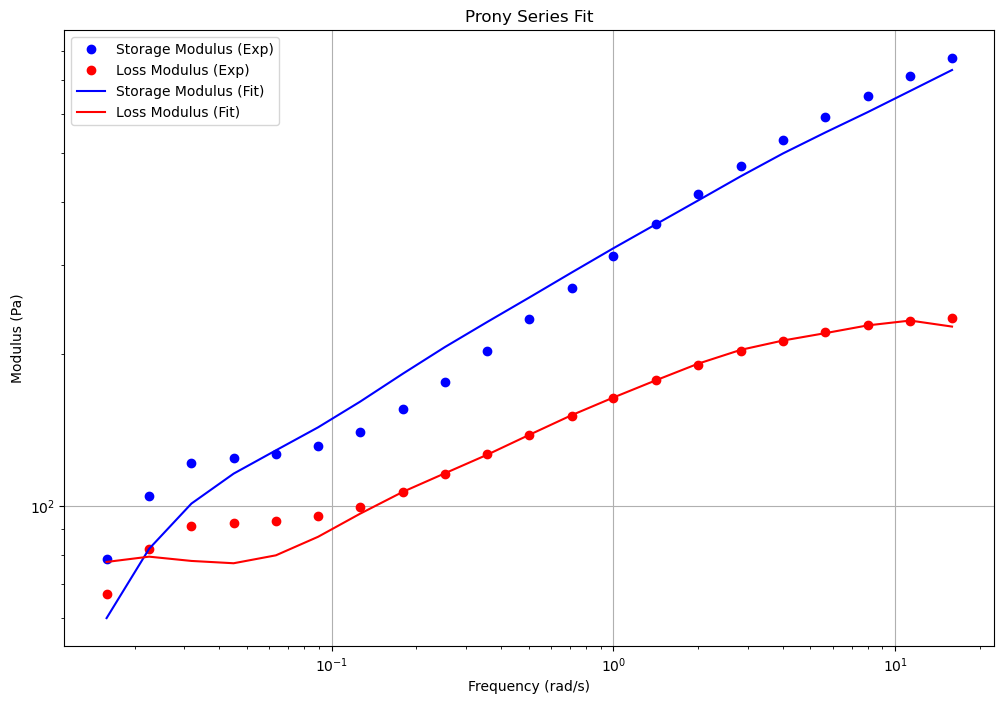

In [13]:
import numpy as np
from scipy.optimize import differential_evolution
import pandas as pd
import matplotlib.pyplot as plt
import os

No_Prony = 10
def read_data(file_path):
    """
    Read experimental data from the Excel file.
    """
    df = pd.read_excel(file_path)
    frequency = df['Frequency'].values
    storage_modulus = df['Storage-Modulus'].values
    loss_modulus = df['Loss-Modulus'].values
    return frequency, storage_modulus, loss_modulus

def prony_series(params, omega):
    """
    Calculate storage and loss moduli using Prony series.
    """
    E0 = params[0]
    gi = params[1::2]
    tau_i = params[2::2]
    
    storage = E0 * (1 - np.sum(gi) + np.sum(gi[:, np.newaxis] * (omega**2 * tau_i[:, np.newaxis]**2) / (1 + omega**2 * tau_i[:, np.newaxis]**2), axis=0))
    loss = E0 * np.sum(gi[:, np.newaxis] * omega * tau_i[:, np.newaxis] / (1 + omega**2 * tau_i[:, np.newaxis]**2), axis=0)
    
    return storage, loss

def objective_function(params, omega, storage_exp, loss_exp):
    """
    Objective function to minimize: mean absolute percentage error (MAPE)
    """
    storage_calc, loss_calc = prony_series(params, omega)
    
    mape_storage = np.mean(np.abs((storage_exp - storage_calc) / storage_exp)) * 100
    mape_loss = np.mean(np.abs((loss_exp - loss_calc) / loss_exp)) * 100
    
    return mape_storage + mape_loss

def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def fit_prony_series(omega, storage_exp, loss_exp, n_terms):
    """
    Fit Prony series parameters using differential evolution.
    """
    E0_min, E0_max = 0.5 * np.min(storage_exp), 2 * np.max(storage_exp)
    
    bounds = [(E0_min, E0_max)]  # Bounds for E0
    for _ in range(n_terms):
        bounds.extend([(0, 1), (1/np.max(omega), 1/np.min(omega))])  # Bounds for gi and tau_i

    result = differential_evolution(
        objective_function,
        bounds,
        args=(omega, storage_exp, loss_exp),
        strategy='best1bin',
        maxiter=1000,
        popsize=15,
        tol=1e-7,
        mutation=(0.5, 1),
        recombination=0.7
    )

    return result.x

def adaptive_fit_prony_series(omega, storage_exp, loss_exp, max_terms=No_Prony):
    """
    Adaptively fit Prony series by increasing the number of terms and selecting the best fit.
    """
    best_params = None
    best_mape = np.inf
    best_n_terms = 0

    for n_terms in range(1, max_terms + 1):
        params = fit_prony_series(omega, storage_exp, loss_exp, n_terms)
        storage_fit, loss_fit = prony_series(params, omega)
        
        mape_storage = calculate_mape(storage_exp, storage_fit)
        mape_loss = calculate_mape(loss_exp, loss_fit)
        mape_avg = (mape_storage + mape_loss) / 2

        print(f"Terms: {n_terms}, MAPE (avg): {mape_avg:.4f}%")

        if mape_avg < best_mape:
            best_mape = mape_avg
            best_params = params
            best_n_terms = n_terms

    print(f"Best fit achieved with {best_n_terms} terms. MAPE: {best_mape:.4f}%")
    return best_params, best_n_terms

def plot_results(omega, storage_exp, loss_exp, best_params):
    """
    Plot experimental data and fitted curves.
    """
    storage_fit, loss_fit = prony_series(best_params, omega)

    plt.figure(figsize=(12, 8))
    plt.loglog(omega, storage_exp, 'bo', label='Storage Modulus (Exp)')
    plt.loglog(omega, loss_exp, 'ro', label='Loss Modulus (Exp)')
    plt.loglog(omega, storage_fit, 'b-', label='Storage Modulus (Fit)')
    plt.loglog(omega, loss_fit, 'r-', label='Loss Modulus (Fit)')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Modulus (Pa)')
    plt.legend()
    plt.title('Prony Series Fit')
    plt.grid(True)
    plt.show()

def main():
    # File path
    file_path = r"M:\citg\se\WR\Moisture Damage\Mahmoud PhD\Publication\SARA Fractions Modeling\Codes\Testdata_Einf.xlsx"
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return

    # Read data
    omega, storage_exp, loss_exp = read_data(file_path)

    # Fit Prony series adaptively
    best_params, n_terms = adaptive_fit_prony_series(omega, storage_exp, loss_exp)

    # Extract parameters
    E0 = best_params[0]
    gi = best_params[1::2]
    tau_i = best_params[2::2]

    # Print results
    print(f"\nFinal Results:")
    print(f"Optimized long-term modulus (E0): {E0:.2f} Pa")
    print(f"Number of Prony terms: {n_terms}")
    print("Prony series parameters:")
    for i, (g, tau) in enumerate(zip(gi, tau_i)):
        print(f"g{i+1} = {g:.4f}, tau{i+1} = {tau:.4f} s")
    print(f"Sum of g_i: {np.sum(gi):.4f}")

    # Plot results
    plot_results(omega, storage_exp, loss_exp, best_params)

if __name__ == "__main__":
    main()